# Binary Classification for patient's smoking status
Overview: https://www.kaggle.com/competitions/playground-series-s3e24/overview


## 0) Intro -  Objective 


Your Goal: For this Episode of the Series, your task is to use binary classification to predict a patient's smoking status given information about various other health indicators. Good luck!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


## 1) Import of packages

In [1]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

optuna.logging.set_verbosity(optuna.logging.WARNING)

data/smoking_dataset.csv
data/test.csv
data/test_dataset_original.csv
data/train.csv
data/train_dataset_original.csv


## 1) Load the data and check structure

In [2]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

train_data_original = pd.read_csv("data/train_dataset_original.csv")
test_data_original = pd.read_csv("data/test_dataset_original.csv")

### Original dataset containt smoking status also for the test set above
smoking_data_original = pd.read_csv("data/smoking_dataset.csv",index_col='ID')

print("Shapes before merge", train_data.shape, train_data_original.shape, test_data_original.shape, smoking_data_original.shape)

print("Check data consistency:")
def row_subset(df1, df2):
    return set(map(tuple,df1.to_numpy())).issubset(map(tuple,df2.to_numpy()))

print(row_subset(train_data_original, smoking_data_original.drop(['gender','oral','tartar'],axis=1)))
print(row_subset(test_data_original, smoking_data_original.drop(['gender','oral','tartar','smoking'],axis=1)))


smoking_data_original = smoking_data_original.drop(['gender','oral','tartar'],axis=1)
smoking_data_original = smoking_data_original.drop_duplicates()
print("smoking shape after removing duplicates", smoking_data_original.shape)

### Let's append the original data to this dataset to increse data points
train_data = pd.concat([train_data, smoking_data_original],axis = 0).reset_index(drop=True)
print("Shapes after merge", train_data.shape)


Shapes before merge (159256, 23) (38984, 23) (16708, 22) (55692, 26)
Check data consistency:
True
True
smoking shape after removing duplicates (44552, 23)
Shapes after merge (203808, 23)


In [3]:
train_data.head()


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1.0,1.0,135.0,87.0,...,40.0,75.0,16.5,1.0,1.0,22.0,25.0,27.0,0,1
1,70,165,65,89.0,0.6,0.7,2.0,2.0,146.0,83.0,...,57.0,126.0,16.2,1.0,1.1,27.0,23.0,37.0,1,0
2,20,170,75,81.0,0.4,0.5,1.0,1.0,118.0,75.0,...,45.0,93.0,17.4,1.0,0.8,27.0,31.0,53.0,0,1
3,35,180,95,105.0,1.5,1.2,1.0,1.0,131.0,88.0,...,38.0,102.0,15.9,1.0,1.0,20.0,27.0,30.0,1,0
4,30,165,60,80.5,1.5,1.0,1.0,1.0,121.0,76.0,...,44.0,93.0,15.4,1.0,0.8,19.0,13.0,17.0,0,1


#### All numerical variables

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203808 entries, 0 to 203807
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  203808 non-null  int64  
 1   height(cm)           203808 non-null  int64  
 2   weight(kg)           203808 non-null  int64  
 3   waist(cm)            203808 non-null  float64
 4   eyesight(left)       203808 non-null  float64
 5   eyesight(right)      203808 non-null  float64
 6   hearing(left)        203808 non-null  float64
 7   hearing(right)       203808 non-null  float64
 8   systolic             203808 non-null  float64
 9   relaxation           203808 non-null  float64
 10  fasting blood sugar  203808 non-null  float64
 11  Cholesterol          203808 non-null  float64
 12  triglyceride         203808 non-null  float64
 13  HDL                  203808 non-null  float64
 14  LDL                  203808 non-null  float64
 15  hemoglobin       

#### Original data https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

In [5]:
train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

## Select veriables to include

In [6]:
VARIABLES_TO_REMOVE =  [] #['dental caries', "Cholesterol", "systolic", "eyesight(right)", "waist(cm)", "AST", "hearing(right)", 'hearing(left)', 'eyesight(left)', 'Urine protein']
FEATURES = list(set(train_data.columns)-set(["smoking"])-set(VARIABLES_TO_REMOVE))
TARGET = 'smoking'  

## 3) Discover and visualize data to gain insights

##### No missing data

In [7]:
train_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [8]:
test_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [9]:
train_data.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,...,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000,203808.000000
mean,44.285656,165.133606,66.868185,82.799830,1.007095,1.002550,1.024332,1.023993,122.290631,76.692470,...,56.166524,114.701744,14.758770,1.077028,0.891308,25.669203,26.667182,37.057628,0.201391,0.421990
std,11.896734,8.906900,12.649219,9.037021,0.422422,0.415314,0.154077,0.153028,12.951378,9.158813,...,14.162422,31.400248,1.463253,0.361145,0.190565,12.236148,21.604434,36.411949,0.401040,0.493878
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,1.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.800000,0.800000,0.800000,1.000000,1.000000,113.000000,70.000000,...,46.000000,94.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,77.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,23.000000,22.000000,27.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,65.000000,134.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,240.000000,146.000000,...,618.000000,1860.000000,21.100000,6.000000,11.600000,1311.000000,2914.000000,999.000000,1.000000,1.000000


Smoking patients are almost half of the train data

In [10]:
train_data.smoking.value_counts()

0    117803
1     86005
Name: smoking, dtype: int64

In [11]:
train_data.smoking.value_counts()[0]

117803

In [12]:
negative_def = train_data.smoking.value_counts()[0]/len(train_data.smoking)
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.5780096953995918, 1: 0.4219903046004082}

### Plot features distribution

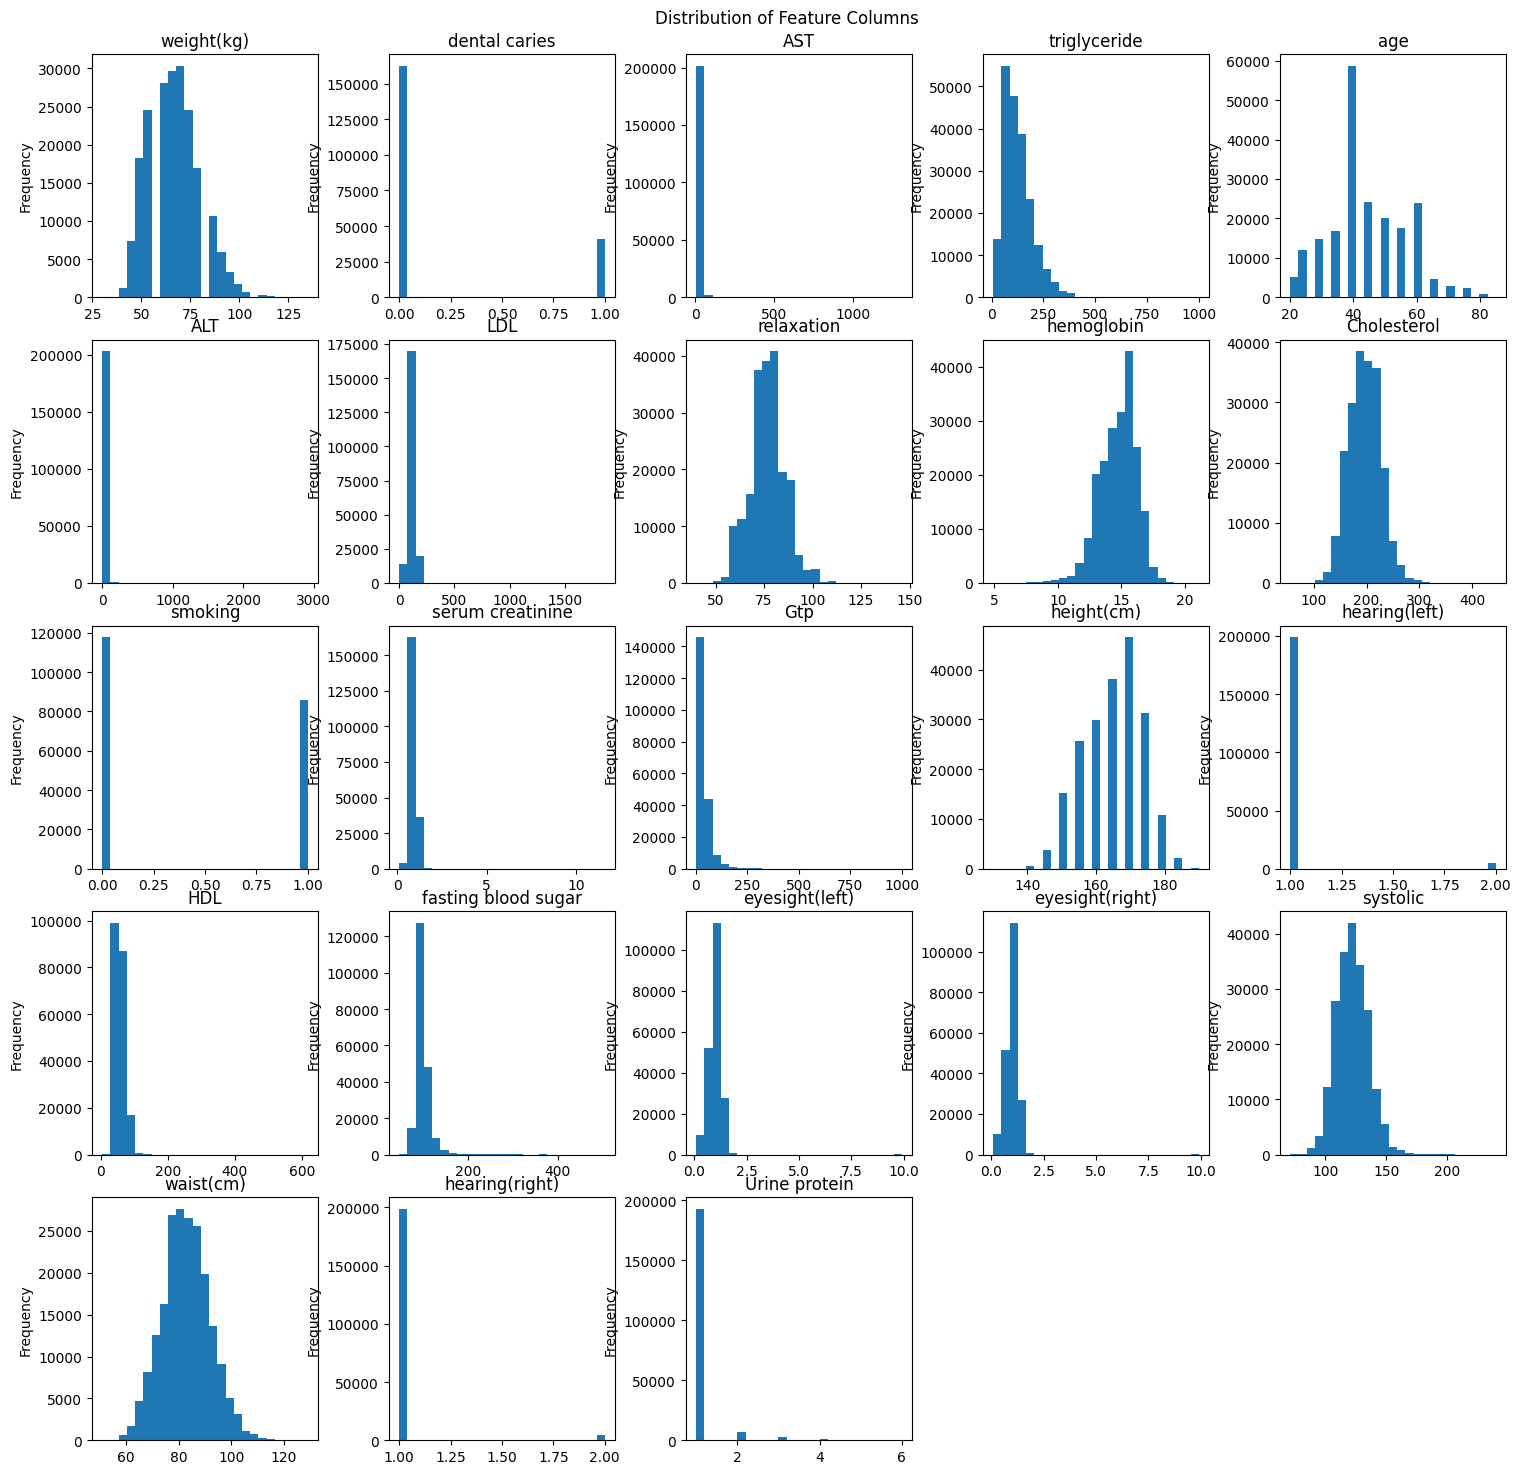

In [13]:
def plot_features_distribution(df):

    feature_columns = set(df.columns)-set(["defects"])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=25, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()

plot_features_distribution(train_data)


### Correlations

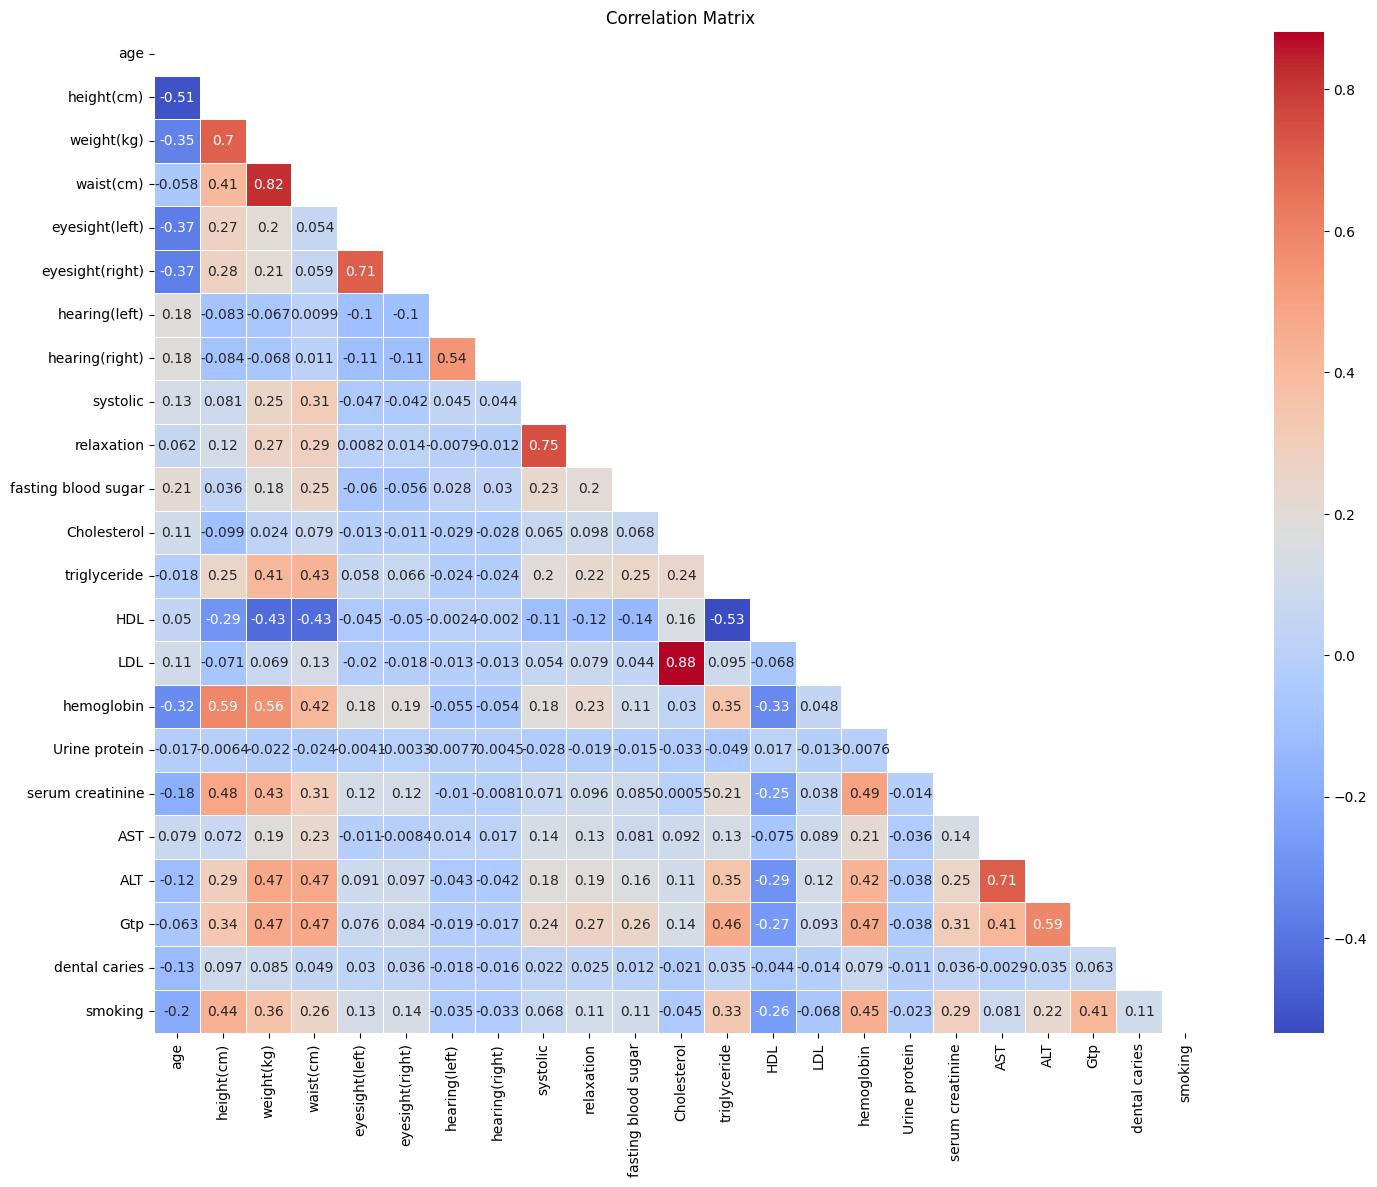

In [14]:
#### Correlation matrix

correlation_matrix = train_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#Relationship: t = e / 18. In the original data, the correlation is perfect. => we can drop t
#Relationship: l = 1 / d => we can drop l

#### Analysis target distribution across features


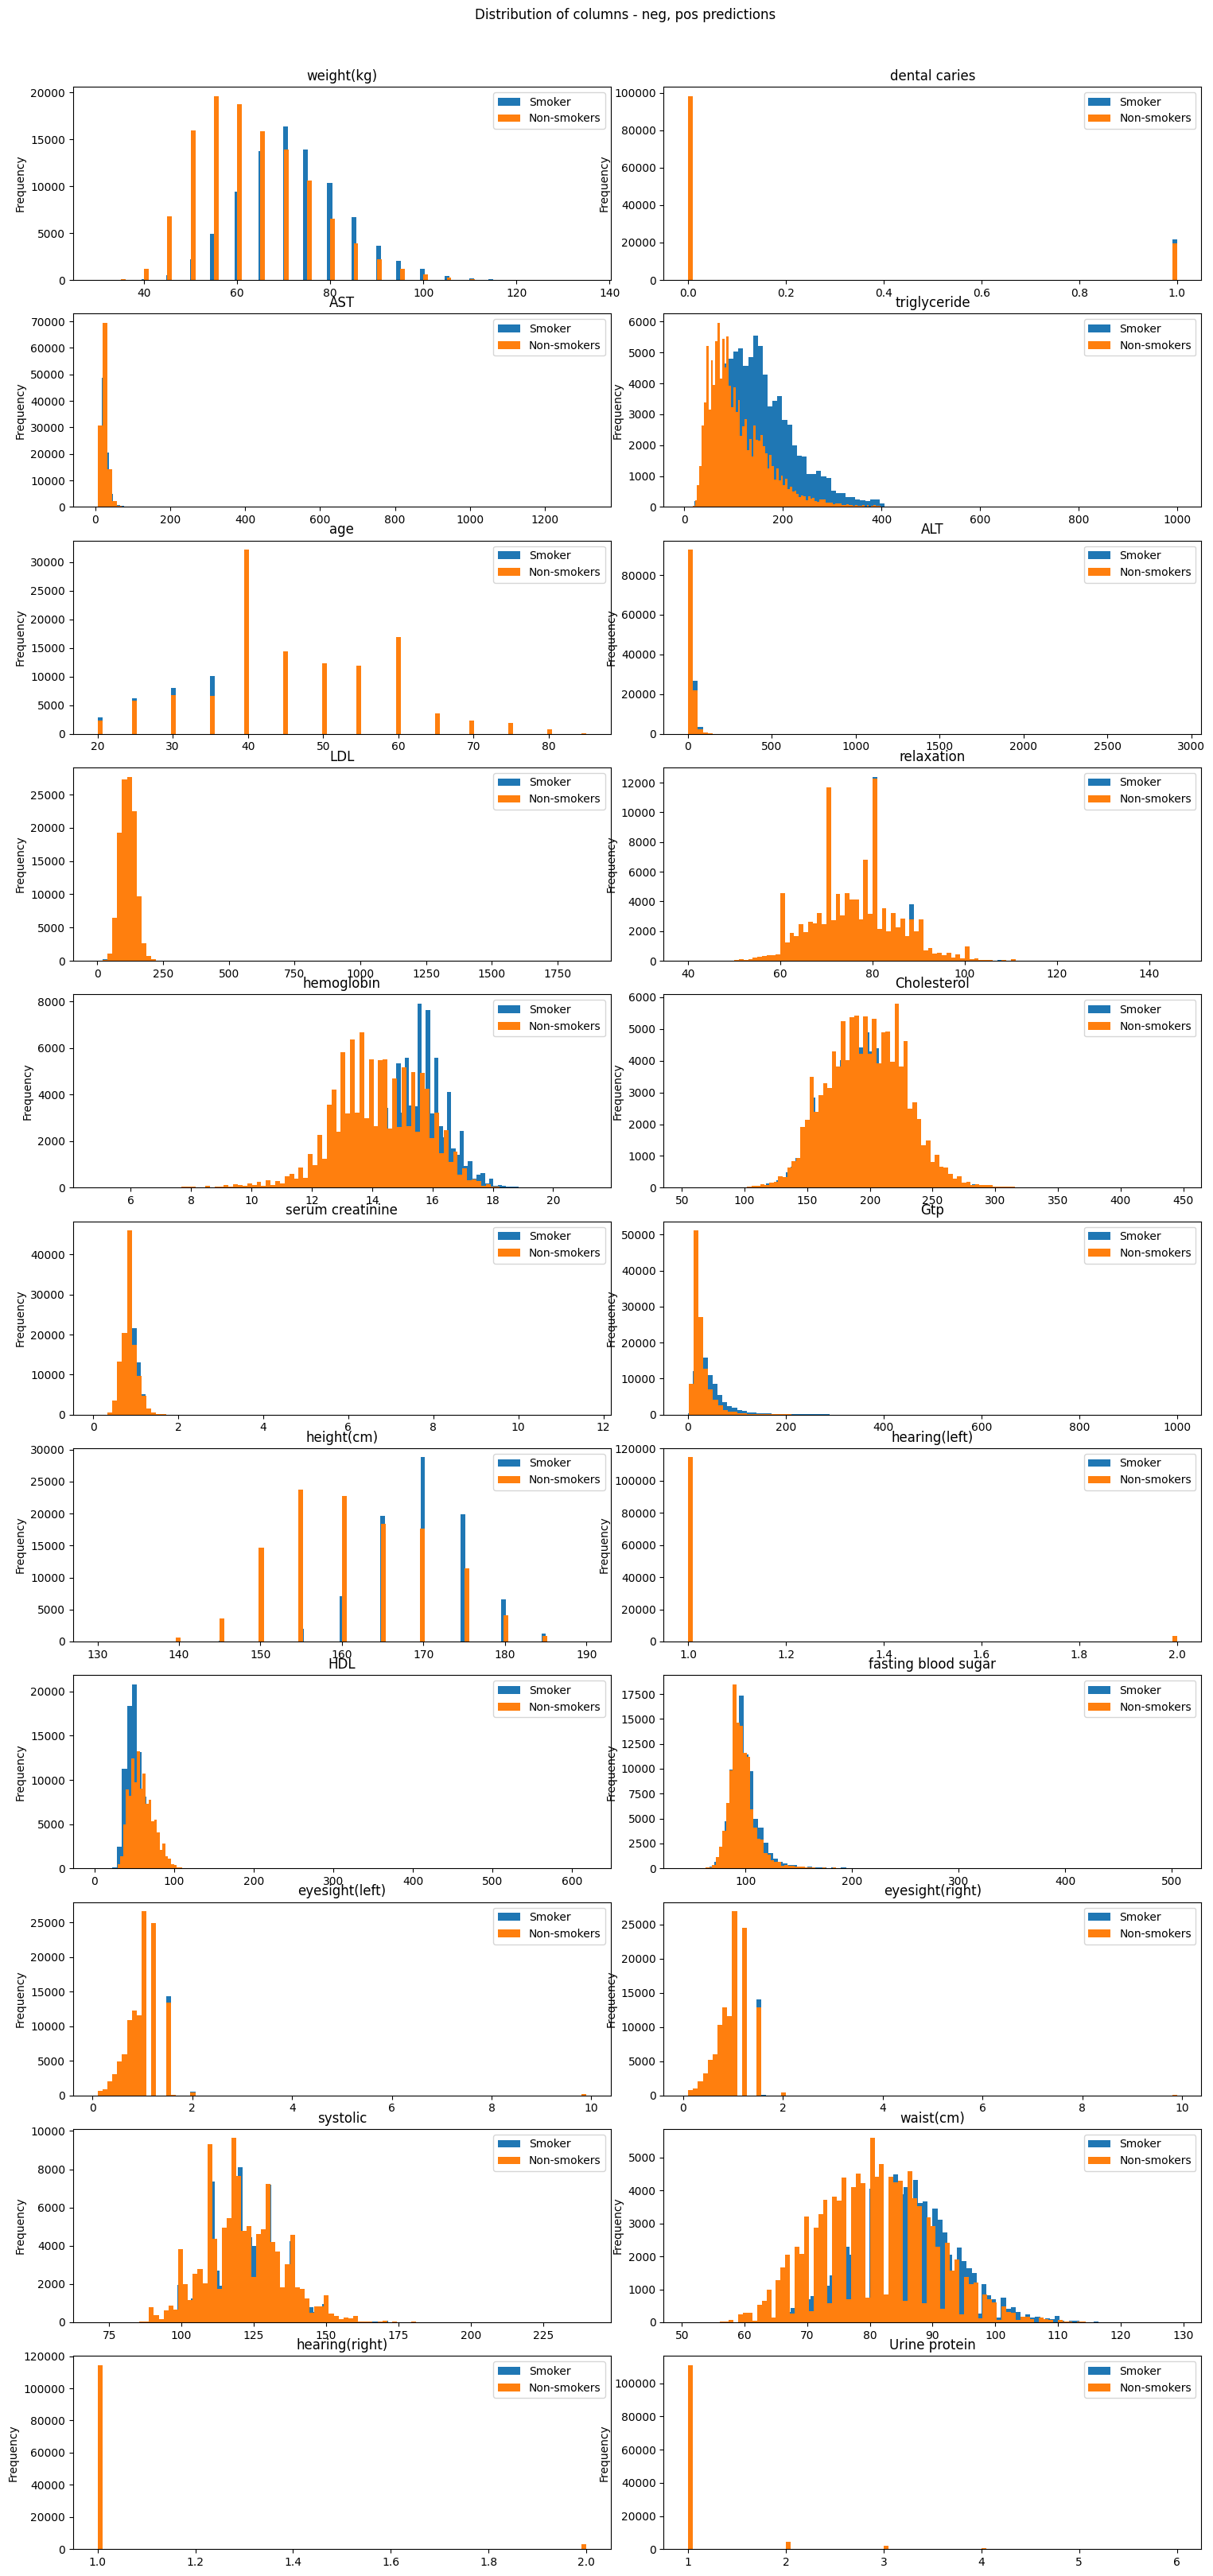

In [15]:
def plot_target_distribution(df, TARGET, FEATURES):

    feature_columns = FEATURES

    negative_pred = df[abs(df[TARGET])<=0.5]
    positive_pred = df[abs(df[TARGET])>0.5]

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 1) // 2
    num_cols = min(len(feature_columns), 2)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        positive_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        negative_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)

        #sns.displot(good_pred, x="n", bins=20).set(title='Points by Team')

        ax.set_ylabel('Frequency')
        ax.legend(['Smoker', 'Non-smokers'])

    # Add a title to the overall picture
    plt.suptitle("Distribution of columns - neg, pos predictions")
    # Show the plot
    plt.show()

plot_target_distribution(train_data, TARGET, FEATURES)

### Observations
Some variables are particularly correlated with smoking:
- height, weight, waist, triglyceride, hemoglobin, Gtp (positively), age and HDL (negatively)
- many variables are normally distributed without transformations
- Consider removing highly correlated variables: "Cholesterol", "systolic", "eyesight(right)", "waist(cm)", "AST" or transform them
- There seems to be a strong differences in the distrbutions of smoking/non-smoking for the following features: Hemoglobin, waist, HDL and triglyceride, dental caries
- Gender is an important variable missing here, but present in the original dataset. Its role is partially visible in variables like height and weight (men are on average taller and heavier)

## Feature engineering

Source: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314

In [16]:
train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

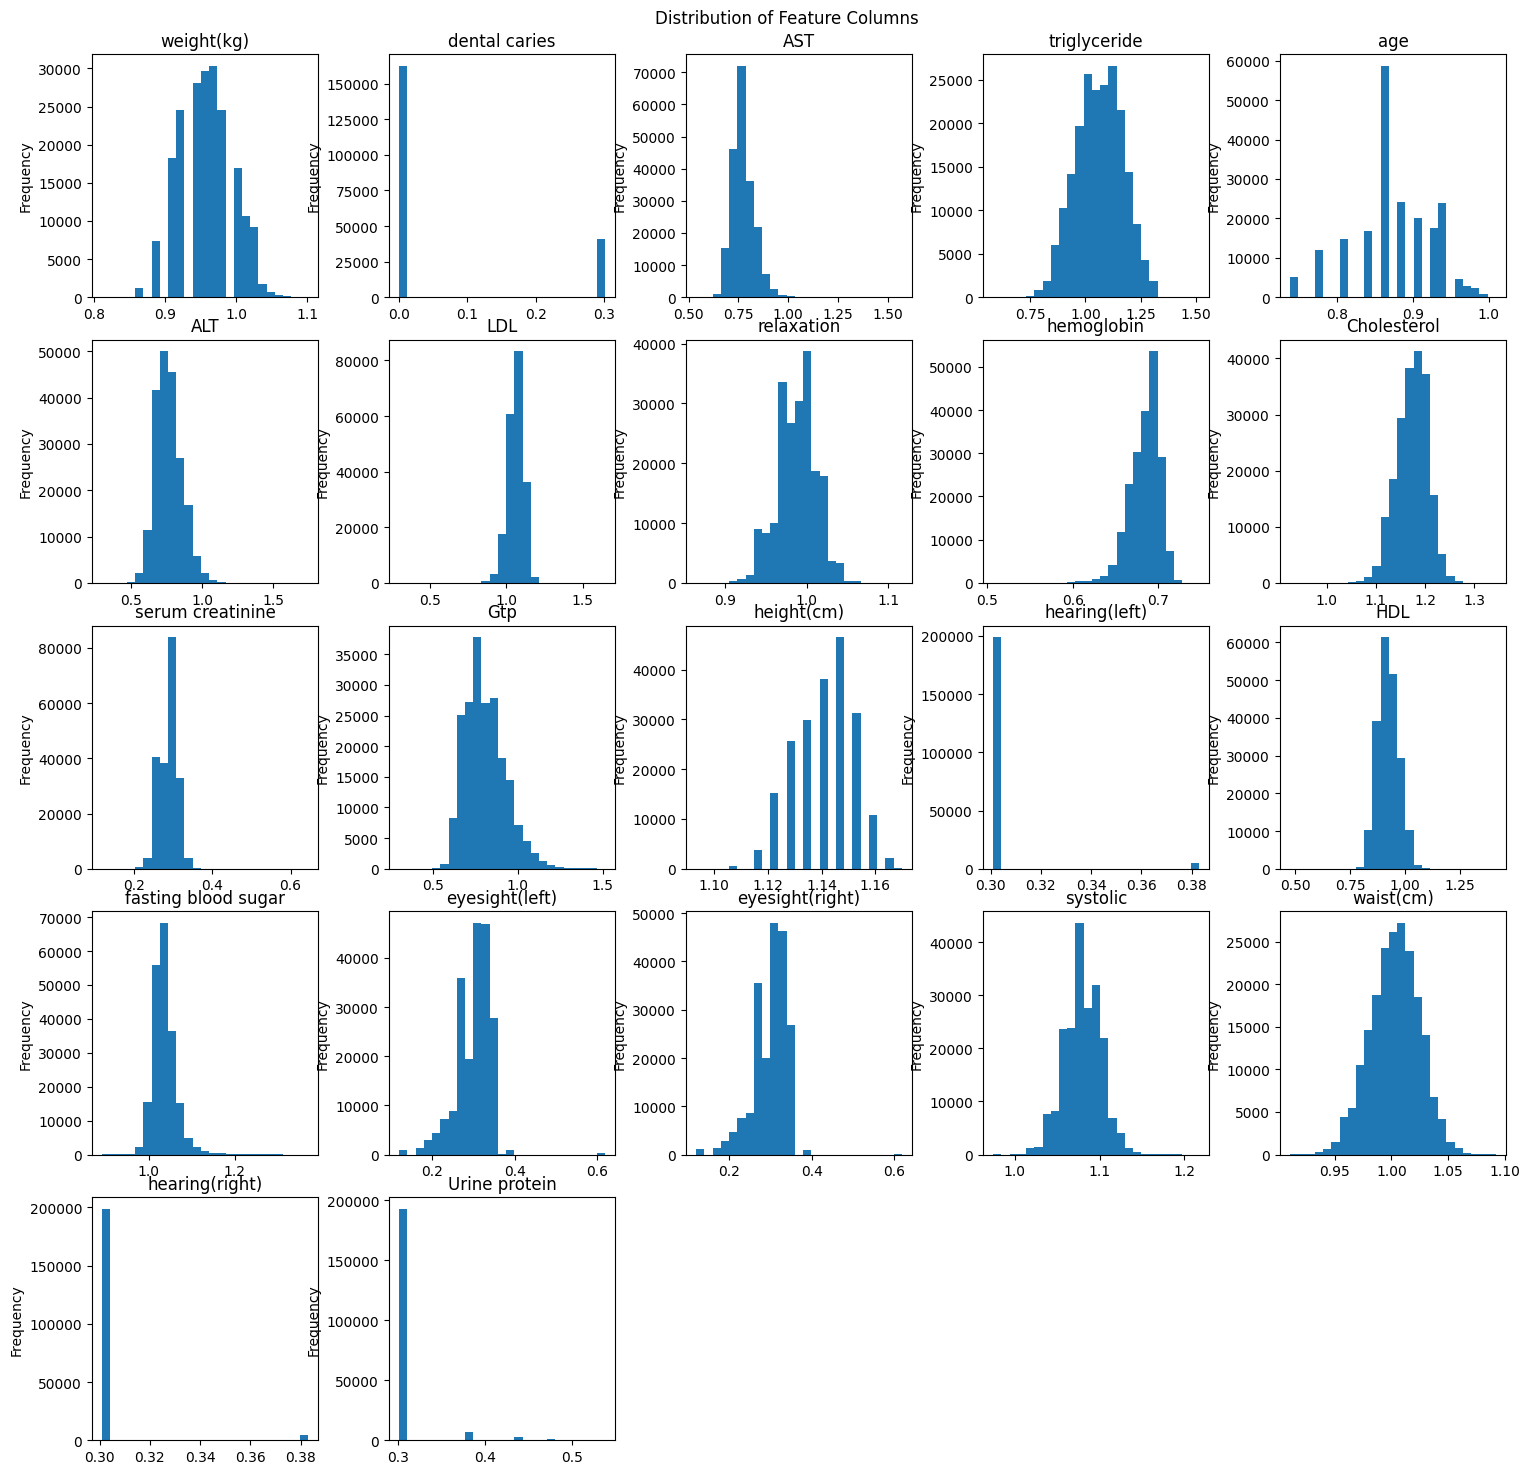

In [17]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_features(df):

    features_df = df.columns
    df = df.copy()

    # ## Create new features
    # df["BMI"] = df['weight(kg)']/(df['height(cm)']/100)**2

    # intervals_bmi = [0, 18.5, 25, 30, 35, 40, 100]  # Modify these intervals as needed
    # labels_bmi = [1, 2, 3, 4, 5, 6]
    # df['BMI_grade'] = pd.cut(df['BMI'], bins=intervals_bmi, labels=labels_bmi, right=False).cat.codes

    # intervals_waist = [0, 94, 102, 300]  # Modify these intervals as needed
    # labels_waist = [1, 2, 3]
    # df['obesity_risk'] = pd.cut(df['waist(cm)'], bins=intervals_waist, labels=labels_waist, right=False).cat.codes

    # intervals_age = [0, 45, 100]  # Modify these intervals as needed
    # labels_age = [1, 2]
    # df['age_risk'] = pd.cut(df['age'], bins=intervals_age, labels=labels_age, right=False).cat.codes

    # intervals_bp = [0, 120, 130, 140, 180, 300]  # Modify these intervals as needed
    # labels_bp = [0, 1, 2, 3, 4]
    # df['blood_pressure_risk'] = pd.cut(df['systolic'], bins=intervals_bp, labels=labels_bp, right=False).cat.codes

    # intervals_col = [0, 200, 240, 1000]  # Modify these intervals as needed
    # labels_col = [ 1, 2, 3]
    # df['cholesterol_riks'] = pd.cut(df['Cholesterol'], bins=intervals_col, labels=labels_col, right=False).cat.codes

    # intervals_hdl = [0, 40, 60, 1000]  # Modify these intervals as needed
    # labels_hdl = [1, 2, 3]
    # df['hdl_risk'] = pd.cut(df['HDL'], bins=intervals_hdl, labels=labels_hdl, right=False).cat.codes

    # intervals_ldl = [0, 100, 130, 160, 190, 2000]  # Modify these intervals as needed
    # labels_ldl = [1, 2, 3, 4, 5]
    # df['ldl_risk'] = pd.cut(df['LDL'], bins=intervals_ldl, labels=labels_ldl, right=False).cat.codes

    # intervals_trig = [0, 150, 200, 500, 1000]  # Modify these intervals as needed
    # labels_trig = [1, 2, 3, 4]
    # df['triglyceride_risk'] = pd.cut(df['triglyceride'], bins=intervals_trig, labels=labels_trig, right=False).cat.codes

    ## Trasform original variables 
    df = np.sqrt(df)
    df =  np.log10(df+1)
    # df_new = df_new.apply(lambda x: yeojohnson(x)[0])

    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(df_new)
    # df_new = pd.DataFrame(scaled_data, columns=df_new.columns,  index=df.index)

    return df

full_enhanced=  edit_X_features(train_data[FEATURES])
plot_features_distribution(full_enhanced)


## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [18]:
VARIABLES_TO_REMOVE =  [] #['dental caries', "Cholesterol", "systolic", "eyesight(right)", "waist(cm)", "AST", "hearing(right)", 'hearing(left)', 'eyesight(left)', 'Urine protein']
FEATURES = list(set(train_data.columns)-set(["smoking"])-set(VARIABLES_TO_REMOVE))
TARGET = 'smoking'  

In [19]:
y = train_data.copy()[TARGET].astype(int)

X_test = test_data[FEATURES].copy()
X = edit_X_features(train_data.copy()[FEATURES])

X_test = edit_X_features(X_test)

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

### Cross validation strategy

In [20]:
nr_folds = 10
kfold = KFold(n_splits=nr_folds,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=nr_folds,shuffle=True,random_state=0)

### Simple logistic regression

In [21]:
def logistic_predictions(train_X, train_y):

    reg = LogisticRegression()
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.8291078955924392
ROC-AUC score validation 0.8278104433310062


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### I) XGB Classifier

In [22]:
OPTUNA = False

xgb_params = {'objective':'binary:logistic', 
              'n_estimators':600,
              'learning_rate':0.1,
              'colsample_bytree':0.5,
              'tree_method':'hist',
              'max_depth':None,
              'gamma':0,
            #   'scale_pos_weight':negative_def/positive_def,
              'random_state':0}

# xgb_params = {'objective':'binary:logistic', 
#               'n_estimators':120,
#               'learning_rate':0.03858856691681774,
#               'max_depth':None,
#               'gamma':14,
#               'scale_pos_weight':negative_def/positive_def,
#               'random_state':0}

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params, optuna):

    reg = xgb.XGBClassifier(eval_metric  = "mape", **xgb_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':trial.suggest_int('n_estimators',50,500),
                  'learning_rate':trial.suggest_float('learning_rate',0.03,0.3),
                  'max_depth':None,
                  'gamma':trial.suggest_int('gamma',0,15),
                  'scale_pos_weight':negative_def/positive_def,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            xgb_auc_score_avg += xgb_val_auc_fold
            
        xgb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=10, show_progress_bar=True, n_jobs=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)


if OPTUNA == True:
    xgb_params = best_xgb_params

xgb_predictions_val, xgb_model, xgb_val_auc = XGBoost_predictions(train_X, train_y,val_X, val_y, xgb_params, False)
#xgb_model.score


ROC-AUC score training 0.9106059530352703
ROC-AUC score validation 0.867144865494181


### II) Random forest classifier

In [23]:
OPTUNA = False

rf_params = { 'n_estimators':883,
              'max_depth':14,
              'min_samples_split':5,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

# rf_params = { 'n_estimators':935,
#               'max_depth':10,
#               'min_samples_split':3,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, optuna):

    reg = RandomForestClassifier(**rf_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def rf_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
              'max_depth':trial.suggest_int('max_depth',1,15),
              'min_samples_split':trial.suggest_int('min_samples_split',2,7),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

        rf_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            rf_auc_score_avg += rf_val_auc_fold
            
        rf_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -rf_auc_score_avg

    rf_study = optuna.create_study()
    rf_study.optimize(rf_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
    best_rf_params = rf_study.best_trial.params

    print('Best RF hyper parameters:', best_rf_params)

if OPTUNA == True:
    rf_params = best_rf_params

random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, False)

ROC-AUC score training 0.9226667379200107
ROC-AUC score validation 0.8563894730130681


### III) ExtraTreesClassifier

In [24]:
OPTUNA = False

# et_params = { 'n_estimators':993,
#               'max_depth':99,
#               'max_features':'auto',
#               'min_samples_split':10,
#               'min_samples_leaf':1,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':False,
#               'n_jobs' :-1}

et_params = { 'n_estimators':1000,
              'max_depth':16,
              'max_features':'auto',
              'min_samples_split':9,
              'min_samples_leaf':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, optuna):

    reg = ExtraTreesClassifier(**et_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def extratree_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
              'max_depth':trial.suggest_int('max_depth',1,100),
              'max_features':'auto',
              'min_samples_split':trial.suggest_int('min_samples_split',2,10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}
        
        et_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            et_auc_score_avg += et_val_auc_fold
            
        et_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -et_auc_score_avg

    et_study = optuna.create_study()
    et_study.optimize(extratree_objective, n_trials=20, n_jobs=10, show_progress_bar=True)
    best_et_params = et_study.best_trial.params

    print('Best Extratree hyper parameters:', best_et_params)

if OPTUNA == True:
    et_params=best_et_params
    
extratree_classifier_predictions_val, extratree_model, extrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, False)

ROC-AUC score training 0.8683192849259899
ROC-AUC score validation 0.8397556824541073


### IV) Logistic regression with Nyström kernel approximation

In [25]:
OPTUNA = False
nystroem_params = {'n_components':384}

def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, optuna):

    # Standardize the features (optional but recommended)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_X)
    X_test = scaler.transform(val_X)

    # Create a Nystroem feature map
    nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

    # Apply the feature map to both the training and testing data
    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    # Create and train the logistic regression model
    reg = LogisticRegression()
    reg.fit(X_train_nystroem, train_y)

    # Make predictions on the test set
    predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(X_test_nystroem)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        X_train_nystroem_full = nystroem.fit_transform(pd.concat([train_X, val_X]))
        reg.fit(X_train_nystroem_full,pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def nystroem_objective(trial):
        params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
        ny_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            
            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True)
            ny_auc_score_avg += ny_val_auc_fold
            
        ny_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -ny_auc_score_avg

    ny_study = optuna.create_study()
    ny_study.optimize(nystroem_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
    best_ny_params = ny_study.best_trial.params

    print('Best nystroem logistic hyper parameters:', best_ny_params)

if OPTUNA ==True:
    nystroem_params=best_ny_params
    
# nystroem_params = best_ny_params
nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, False)

c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC score training 0.8493527925179507
ROC-AUC score validation 0.8481350334554615


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### V) CatBoostClassifier

In [26]:
OPTUNA = False

cb_params = {'iterations': 1103,
            'depth': 6,
            'learning_rate': 0.10220287159013668,
            'l2_leaf_reg': 1,
            'loss_function':'Logloss',
            'verbose':0,
            'random_seed':42,
            'class_weights':class_weights
            }

def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, optuna):

    reg = CatBoostClassifier(**cb_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def catboost_objective(trial):

        # Set the hyperparameters of the Random forest classifier.

        params = {'iterations':trial.suggest_int('iterations',500, 2000),
              'depth':trial.suggest_int('depth',1,10),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',1,10),
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }
        
        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            cb_auc_score_avg += cb_val_auc_fold
            
        cb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(catboost_objective, n_trials=100, n_jobs=10, show_progress_bar=True)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyper parameters:', best_cb_params)

if OPTUNA == True:
    cb_params=best_cb_params

catbost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, True)

ROC-AUC score training 0.8971199729560446
ROC-AUC score validation 0.865838585516076


## Feature importance

Text(0.5, 1.0, 'Feature Importance')

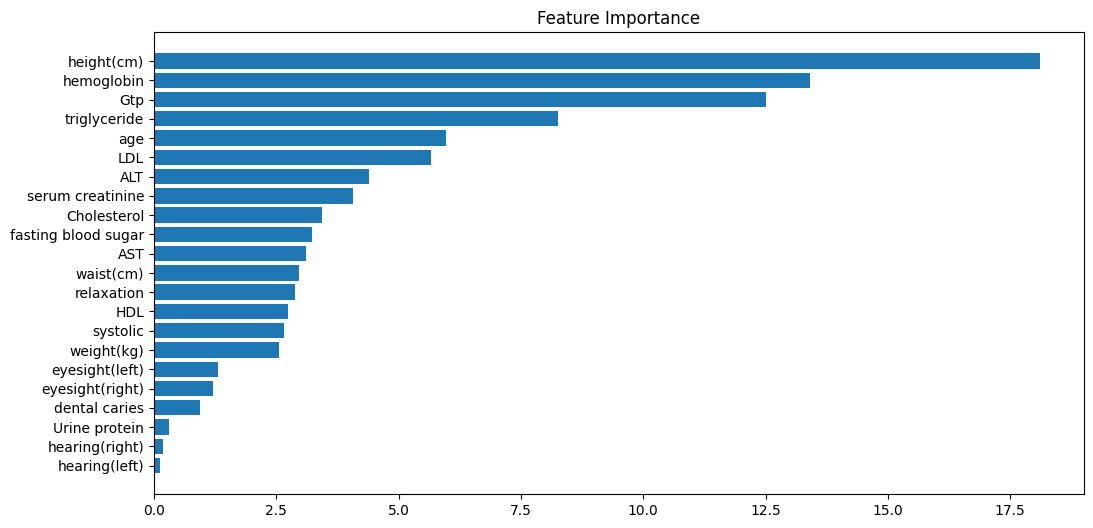

In [27]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


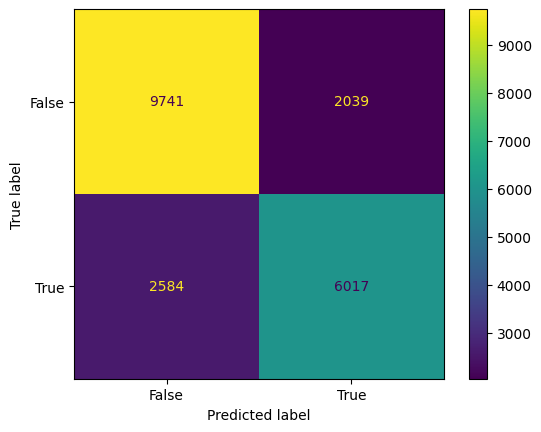

In [28]:
predictions_conf = [0 if x < 0.5 else 1 for x in catbost_classifier_predictions_val]
predictions_conf

confusion_matrix = metrics.confusion_matrix(val_y, predictions_conf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### VI) LGBMClassifier

In [30]:
OPTUNA = False

lgbm_params = { 'boosting_type':'gbdt',
              'num_leaves':17,
              'learning_rate':0.013240041792690652,
              'n_estimators':431,
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }

def lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, optuna):

    reg = lgb.LGBMClassifier(**lgbm_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def lgbm_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
     
        params = { 'boosting_type':'gbdt',
              'num_leaves':trial.suggest_int('num_leaves',10, 200),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'n_estimators':trial.suggest_int('n_estimators',100, 2000),
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }
        
        lgbm_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            lgbm_auc_score_avg += lgbm_val_auc_fold
            
        lgbm_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -lgbm_auc_score_avg

    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_objective, n_trials=100, n_jobs=10, show_progress_bar=True)
    best_lgbm_params = lgbm_study.best_trial.params

    print('Best lgbm hyper parameters:', best_lgbm_params)

if OPTUNA == True:
    lgbm_params = best_lgbm_params

lgbm_classifier_predictions_val, lgbm_model, lgbm_val_auc= lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, False)

ROC-AUC score training 0.8579561107708884
ROC-AUC score validation 0.855652864623275


### VII) HistGradientBoostingClassifier

#### Single Execution

In [31]:
OPTUNA = False
hgbc_params =  {'max_iter': 477, 
                'learning_rate': 0.04584446359126259, 
                'max_depth': 3, 
                'l2_regularization': 0.0822627761827129, 
                'random_state':42,}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, optuna):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=100, n_jobs=10, show_progress_bar=True)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

if OPTUNA==True:
    hgbc_params = best_hgbc_params

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, False)

ROC-AUC score training 0.8614503350541225
ROC-AUC score validation 0.8591285630505713


### VIII) Neural network

In [32]:
nn_params =  {"hidden_layer_sizes":(20, 10, 10, 5), 
              "activation":'relu', 
              "max_iter":500, 
              "random_state":42}

def neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, optuna):
    # Create an MLPClassifier (Multi-layer Perceptron) neural network
    # You can customize the architecture by adjusting the hidden_layer_sizes and other parameters.
    reg = MLPClassifier(**nn_params)

    # Train the model
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))
    
    return predictions, reg, val_auc

nn_classifier_predictions_val, nn_model, nn_val_auc = neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, False)

ROC-AUC score training 0.8429529832751439
ROC-AUC score validation 0.8416598812196394


## Check AUC-ROC

In [ ]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
# plot_roc(val_y,log_predictions)

### Rank models by performance

In [ ]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgb_predictions_val),
                       'rf':roc_auc_score(val_y,random_forest_predictions_val),
                       'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       'log':roc_auc_score(val_y,log_predictions_val),
                       'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catbost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                       'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),     
                       'neural':roc_auc_score(val_y,nn_classifier_predictions_val),     
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


### Optimize weights for the ensamble with Optuna (on initial validation set)

In [ ]:
ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val,
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val,
                            extratree_classifier_predictions_val, nn_classifier_predictions_val]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

In [ ]:
if False:

  optuna.logging.set_verbosity(optuna.logging.WARNING)

  def ensamble_objective(trial):
    STEP_SIZE = 2

    weights = []
    all_models_predictions = []

    # we'll use a variable for setting upper limit for suggested value
    # since we intend to update it after each weight suggestion
    upper_limit = 100

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    upper_limit -= w_xgb
    upper_limit = upper_limit

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    upper_limit -= w_catboost
    upper_limit = upper_limit

    w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_nystroem)

    upper_limit -= w_nystroem
    upper_limit = upper_limit

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    upper_limit -= w_hgbc
    upper_limit = upper_limit

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    upper_limit -= w_lgbm
    upper_limit = upper_limit

    w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_rf)

    # w_extratree = 100 - sum(weights)
    # weights.append(w_extratree)

    w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_extratree)

    w_neural = trial.suggest_int("w_neural", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_neural)

    # Just as a sanity check, we'll check that the sum of all weights is equal to 100
    weights_sum = sum(weights)
    # if weights_sum != 100:
    #   raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val,nn_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=2000, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  # best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


In [ ]:
# Manual ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version

best_ensamble_params = {'w_xgb': 50,
 'w_catboost': 100,
 'w_nystroem': 0,
 'w_hgbc': 0,
 'w_lgbm': 0,
 'w_rf': 0,
 'w_extratree': 0,
 'w_neural':0}

## Final Prediction for test set

In [42]:
xgb_predictions = xgb_model.predict_proba(X_test)[:,1]
random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pd.concat([train_X, val_X]).copy())
X_test_scaled = scaler.transform(X_test.copy())
n_components = nystroem_params["n_components"] 
nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
X_train_nystroem = nystroem.fit_transform(X_train_scaled)
X_test_nystroem = nystroem.transform(X_test_scaled)
nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]
nn_classifier_predictions = nn_model.predict_proba(X_test)[:,1]


model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, 
                          hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, 
                          extratree_classifier_predictions, nn_classifier_predictions]

final_prediction = np.average(model_predictions_test, weights=list(best_ensamble_params.values()), axis=0)
# final_prediction =  np.average([xgb_predictions, random_forest_predictions, extratree_classifier_predictions, catbost_classifier_predictions], axis=0)

# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, TARGET:final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,smoking
id,
159256,0.572510
159257,0.217768
159258,0.424230


### Submit predictions

In [69]:
submission.to_csv('submissions/9.ensamble_XGB_CB_ET_RF_optuna_optimized_bmi_average.csv')

In [ ]:
w1_weights, w2_weights, w3_weights = list(), list(), list()
w4_weights, scores = list(), list()

for i in tqdm(range(0, 1000)):
    
    w1 = np.random.random_sample(size = 1)[0]
    w2 = np.random.random_sample(size = 1)[0]
    w3 = np.random.random_sample(size = 1)[0]
    w4 = np.random.random_sample(size = 1)[0]
    
    w1_weights.append(w1)
    w2_weights.append(w2)
    w3_weights.append(w3)
    w4_weights.append(w4)
    
    scores_in = list()
    
    for j in range(0, 10):
        
        pred = w1*md8_pred[j] + w2*md9_pred[j] + w3*md7_pred[j] + w4*md6_pred[j]
        scores_in.append(roc_auc_score(Y_test_list[j], pred))
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_xgb'] = w1_weights
results['w_cat'] = w2_weights
results['w_lgb'] = w3_weights
results['w_his'] = w4_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = False).reset_index(drop = True)
results.head(10)

### Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(train_X, train_y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

### Voting classifier trained on the full train dataset

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(X, y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

### Optimize ensambling with Optuna

In [ ]:
def ensamble_objective(trial):
  STEP_SIZE = 5

  weights = []
  all_models_predictions = []

  # we'll use a variable for setting upper limit for suggested value
  # since we intend to update it after each weight suggestion
  upper_limit = 100

  w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_xgb)

  upper_limit -= w_xgb
  upper_limit = upper_limit

  w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_catboost)

  upper_limit -= w_catboost
  upper_limit = upper_limit

  w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_nystroem)

  upper_limit -= w_nystroem
  upper_limit = upper_limit

  w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_hgbc)

  upper_limit -= w_hgbc
  upper_limit = upper_limit

  w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_lgbm)

  upper_limit -= w_lgbm
  upper_limit = upper_limit

  w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_rf)

  w_extratree = 100 - sum(weights)
  weights.append(w_extratree)

  # Just as a sanity check, we'll check that the sum of all weights is equal to 100
  weights_sum = sum(weights)
  if weights_sum != 100:
    raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
  
  auroc_ensamble_avg = 0
  for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

      print("Running fold ", idx)
      train_X_fold = X.iloc[train_idx]
      val_X_fold = X.iloc[val_idx]
      train_y_fold = y[train_idx]
      val_y_fold = y[val_idx]

      # We'll use the default parameter values for all our models  

      xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, xgb_params)
      all_models_predictions.append(xgb_predictions_fold)

      ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, nystroem_params)
      all_models_predictions.append(ny_predictions_fold)

      rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, rf_params)
      all_models_predictions.append(rf_predictions_fold)
      
      cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, cb_params)
      all_models_predictions.append(cb_predictions_fold)

      lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, lgbm_params)
      all_models_predictions.append(lgbm_predictions_fold)
   
      et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, et_params)
      all_models_predictions.append(et_predictions_fold)

      hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, hgbc_params)
      all_models_predictions.append(hgbc_predictions_fold)

      # let's take the weighted average of the predictions using numpy
      y_pred_final_fold = np.average(all_models_predictions, weights=weights, axis=0)
      auroc_ensamble_fold = roc_auc_score(val_y_fold, y_pred_final_fold)
      auroc_ensamble_avg += auroc_ensamble_fold

      all_models_predictions = []

  auroc_ensamble_avg /=nr_folds

  return -auroc_ensamble_avg

In [ ]:
ensamble_study = optuna.create_study(study_name="optimizing weights")
ensamble_study.optimize(ensamble_objective, n_trials=100)

best_ensamble_params = ensamble_study.best_trial.params

print('Best ensamble weights:', best_ensamble_params)

In [ ]:
# optuna.visualization.plot_contour(ensamble_study)
# optuna.visualization.plot_param_importances(rf_study)

### Considerations
- 

## Valuable sources
- 

